# InternetFirewallSupervisedLearning
## Author: Tijs van Lieshout

Predicting the Internet Firewall action based on log info. Supervised Learning Assignment for Master DSLS.

### Data availability:
- [Direct link](https://archive.ics.uci.edu/ml/machine-learning-databases/00542/log2.csv)
- [Archive link with some info](https://archive.ics.uci.edu/ml/datasets/Internet+Firewall+Data)
- [F. Ertam and M. Kaya, "Classification of firewall log files with multiclass support vector machine," 2018 6th International Symposium on Digital Forensic and Security (ISDFS), 2018, pp. 1-4, doi: 10.1109/ISDFS.2018.8355382.](https://doi.org/10.1109/ISDFS.2018.8355382)

Table 1. Classes to predict (Actions)

|   Action   |                                                               Description                                                              |
|:----------:|:--------------------------------------------------------------------------------------------------------------------------------------:|
| Allow      | Allows the internet traffic.                                                                                                           |
| Deny       | Blocks traffic and enforces the default Deny Action defined for the application that is being denied.                                  |
| Drop       | Silently drops the traffic; for an application, it overrides the default deny action. A TCP reset is not sent to the host/application. |
| Reset-Both | Sends a TCP reset to both the client-side and server-sidedevices.                                                                      |



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("log2.csv")
df

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [4]:
allow, deny, drop, reset_both = df['Action'].value_counts()
print('Number of allowed logs: ', allow)  
print('Number of denied logs: ', deny)
print('Number of dropped logs: ', drop)  
print('Number of reset-both logs: ', reset_both) 

print('\n')
print('% of allowed logs', round(allow / len(df) * 100, 1), '%')
print('% of denied logs', round(deny / len(df) * 100, 1), '%')
print('% of dropped logs', round(drop / len(df) * 100, 1), '%')
print('% of reset-both logs', round(reset_both / len(df) * 100, 1), '%')

Number of allowed logs:  37640
Number of denied logs:  14987
Number of dropped logs:  12851
Number of reset-both logs:  54


% of allowed logs 57.4 %
% of denied logs 22.9 %
% of dropped logs 19.6 %
% of reset-both logs 0.1 %


<AxesSubplot:>

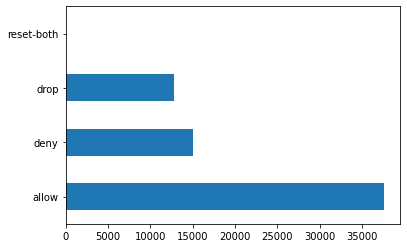

In [5]:
df['Action'].value_counts().plot(kind='barh')

Pretty unbalanced classes to predict

In [6]:
# missing data
df.isnull().sum() 
# no missing data, no imputation needed

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [7]:
description = df.groupby(['Action']).describe()

<AxesSubplot:>

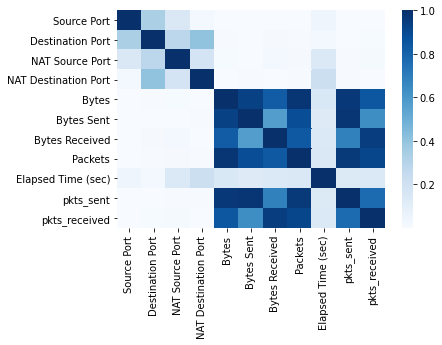

In [8]:
c = df.corr().abs()
sns.heatmap(c, cmap=sns.color_palette("Blues", as_cmap=True))

'Bytes Sent', 'Bytes Received', 'pkts_sent' and 'pkts_received' can be discarded as Bytes and Packets are the total of the two pairs respectively.

I am also going to discard packets for bytes as it is highly correlated. I'll keep Bytes since it is more detailed than packets (1 packet consists of multiple bytes)

All of the port variables should not be seen as continous, but probably are interesting to see the range

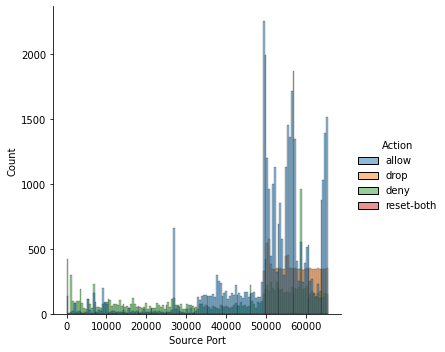

In [9]:
sns.displot(df, x="Source Port", hue="Action")
plt.show()

In [10]:
description['Source Port']

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,51127.933103,12215.084883,0.0,49418.0,53759.0,57369.25,65534.0
deny,14987.0,38557.289317,21098.611314,0.0,18754.0,46573.0,57355.50,65529.0
drop,12851.0,57038.209244,4788.365511,49156.0,52797.0,56846.0,61195.00,65533.0
reset-both,54.0,26722.425926,18382.095784,1024.0,11573.5,22207.5,40013.50,64461.0


All Actions of drop seem to happen in high source ports (minimum 49156). Reset-both Source Port minimum is 1024

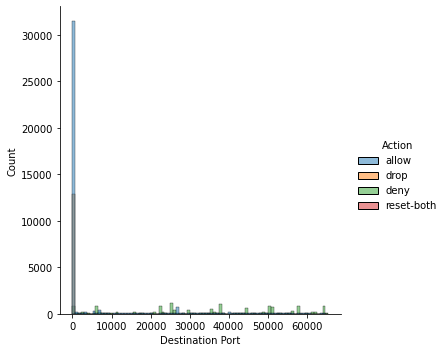

In [11]:
sns.displot(df, x="Destination Port", hue="Action")
plt.show()

In [12]:
description['Destination Port']

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,4728.336265,12573.742340,0.0,53.0,80.0,443.0,65535.0
deny,14987.0,33904.072129,19337.312430,0.0,22114.0,35440.0,50584.0,65504.0
drop,12851.0,445.000000,0.000000,445.0,445.0,445.0,445.0,445.0
reset-both,54.0,24882.333333,18531.926996,1.0,5618.0,25773.0,34021.0,61248.0


Most actions seem to have a very low destination port. All drop actions are done on Destination Port 445

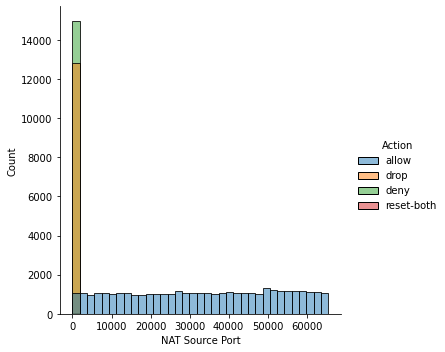

In [13]:
sns.displot(df, x="NAT Source Port", hue="Action")
plt.show()

In [14]:
description['NAT Source Port']

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,33549.797689,19004.048999,0.0,17050.25,33999.5,50341.25,65535.0
deny,14987.0,31.828184,1269.390081,0.0,0.00,0.0,0.00,62347.0
drop,12851.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
reset-both,54.0,6673.648148,15236.959303,0.0,0.00,0.0,0.00,64014.0


Allowed actions seme to be uniformly distributed over NAT Source Ports. All dropped NAT Source Ports are equal to 0. Most deny and reset-both actions have NAT Source Ports of 0.

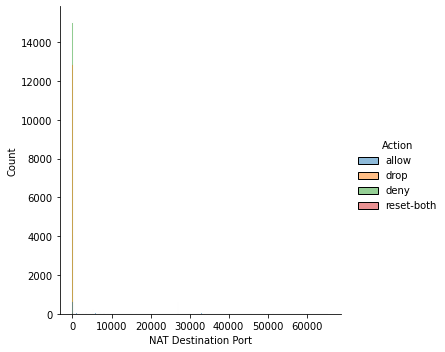

In [15]:
sns.displot(df, x="NAT Destination Port", hue="Action")
plt.show()

In [16]:
description['NAT Destination Port']

,count,mean,std,min,25%,50%,75%,max
Action,,,,,,,,
allow,37640.0,4648.409724,12487.696166,0.0,53.0,80.0,443.0,65535.0
deny,14987.0,2.164142,132.690631,0.0,0.0,0.0,0.0,8889.0
drop,12851.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
reset-both,54.0,753.111111,1422.171667,0.0,0.0,0.0,0.0,3389.0


Allowed actions seme to be uniformly distributed over NAT Destination Ports. All dropped NAT Destination Ports are equal to 0. Most deny and reset-both actions have NAT Destination Ports of 0.

In [17]:
cols = ['Source Port', 
        'Destination Port', 
        'NAT Source Port', 
        'NAT Destination Port', 
        'Bytes', 
        'Elapsed Time (sec)']
df_features = df[cols].rename(columns={'Source Port':'source_port',
                                       'Destination Port':'destination_port', 
                                       'NAT Source Port':'nat_source_port', 
                                       'NAT Destination Port':'nat_destination_port',
                                       'Bytes':'bytes',
                                       'Elapsed Time (sec)':'elapsed_time'})

<AxesSubplot:>

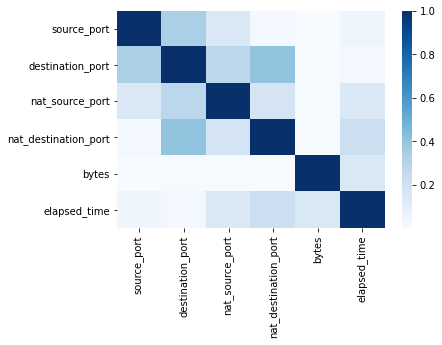

In [18]:
c = df_features.corr().abs()
sns.heatmap(c, cmap=sns.color_palette("Blues", as_cmap=True))

In [19]:
y = np.array(df['Action'].replace({'allow':0,'deny':1,'drop':2, 'reset-both':3}))
X = np.array(df_features)
print(y.shape)
print(X.shape)

(65532,)
(65532, 6)
